# Competitioin 1 Report

### Team baseline

107062530 王宇正
<br>
107062568 葉庭安
<br>
107062552 林振弘
<br>
107062522 張展榕

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import argparse
import jieba

# Preprocessing

In the preprocessing section, we will show that how we convert the text format data into processed binary format

We tried three types of tokenizing mode, include ``jieba``, ``jieba(cut_all=True)``, ``ckip``
ckip has the best single word tokenized. However, because of attention mechanism in our network, ``jieba(cut_all=True)`` work best in our architechure.

Another important implementation detail is that we train our model in context level instead of sentence level, which contain more information to determinate which they are relative.

For a example,

> [‘要不然如果太陽太大的話’, ‘像你這麼漂亮’, ‘可能會曬得很黑’]
<br>
> [‘說得也是’, ‘對啊’, ‘我這才知道’]

are more relative compare with

> [‘要不然如果太陽太大的話’]
<br>
> [‘像你這麼漂亮’]

In [2]:
"""
Invalid character which may influence following steps and performance, so we will take them out
"""

invalid = ['', ' ', '\t']

In [3]:
"""
Jieba configuration, use traditional dictionary for better tokenization
"""

def set_jieba(datadir, num_threads):
    jieba.set_dictionary(datadir + '/dictionary.txt')
    jieba.enable_parallel(num_threads)

In [4]:
"""
Read csv format data into python list
"""

def read_data(datadir):

    programs = []

    for i in range(1, 9):
        program = pd.read_csv(datadir + '/Program0%d.csv' % (i))
        programs.append(program)

    questions = pd.read_csv(datadir + '/Question.csv')

    return programs, questions

In [5]:
"""
Use jieba(cut_all=True) for tokenization, which will help our performance to a new level
"""

def tokenize(sentences, is_question):
    token = []

    for sentence in sentences:
        tokenized_sentence = jieba.lcut(sentence, cut_all=True)
        no_space = [t for t in tokenized_sentence if t not in invalid]
        if no_space:
            if is_question:
                token.extend(no_space)
            else:
                token.append(no_space)
    return token

In [6]:
"""
Tokenize the programs, generate both 
[program[episode[sentence]] and [[sentence]] two formats for differnet usages
"""

def tokenize_programs(programs):
    tokenized_programs = []
    word2vec_train = []

    for program in tqdm(programs, desc='processing programs'):
        tokenized_program = []

        for index in range(len(program)):
            sentences = program.loc[index]['Content'].split('\n')
            tokens = tokenize(sentences, False)
            tokenized_program.append(tokens)
            word2vec_train.extend(tokens)

        tokenized_programs.append(tokenized_program)

    return tokenized_programs, word2vec_train

In [7]:
"""
Tokenize the questions
"""

def tokenize_questions(questions):
    tokenized_questions = []
    n = len(questions)

    for i in tqdm(range(n), desc='processing questions'):
        tokenized_question = []
        sentences = questions.loc[i]['Question'].split('\n')
        tokenized_question.append(tokenize(sentences, True))

        for j in range(6):
            option = questions.loc[i]['Option%d' % (j)]
            tokenized_option = [t for t in jieba.lcut(option, cut_all=True) if t not in invalid]
            tokenized_question.append(tokenized_option)

        tokenized_questions.append(tokenized_question)

    return tokenized_questions

In [8]:
"""
Combine the three consequent sentences as a context, 
We will train whether two contexts have the relationship instead of two sentences
"""

def sentence2context(programs):
    extended_programs = list()
    for program in tqdm(programs, desc='sentence to context'):
        extended_episode = list()
        for episode in tqdm(program):
            extended_sentence = list()
            zip_episodes = zip(episode[:-3], episode[1:-2], episode[2:-1])
            for s0, s1, s2 in zip_episodes:
                extended_sentence.append(s0 + s1 + s2)
            extended_episode.append(extended_sentence)
        extended_programs.append(extended_episode)
    return extended_programs

In [9]:
"""
Save the processed data into disk, reduced re-preprocessing time
"""

def save_npy(data_path, tps, tqs, w2v, eps):
    np.save(data_path + '/tokenized_programs.npy', tps)
    np.save(data_path + '/tokenized_questions.npy', tqs)
    np.save(data_path + '/word2vec_train.npy', w2v)
    np.save(data_path + '/extended_programs.npy', eps)

# Train the word embedding with Fasttext

We use gensim.fasttext for better word embedding. We tested cbow and skip-gram two 
well-known algorithms, skip-gram has better performance if we fix the embedding in training. 
However, if we update the embedding in training, cbow perform a little better.

In the [Fasttext paper](https://arxiv.org/pdf/1607.04606.pdf), it mentions Fasttext works better on small training dataset, and our experiments show that there are 0.04 public score improvement when using
Fasttext embedding compare with word2vec.

Our embedding configurations are 
    * size = 300, too large will let our network hard to learn
    * windows = 12, Chinese representation have longer word to word distance
    * iters = 50, balanced between time spent and accuracy

In [10]:
def train_fasttext(datadir, embeddingdir):
    sentences = np.load(datadir + '/word2vec_train.npy')
    model = FastText(sentences, size=300, window=300, workers=12, iter=50)
    model.save(embeddingdir + '/fasttext.bin')

# Generate training data

Because we want to full utilize the program data, use original random algorithm may get lots of 
deplicated sample, it may cause the bias for worse performance.
So we make sure each sample will use only once by a random shuffled list

In [11]:
"""
Read processed data from disk
"""

def read_data(datadir):
    programs = np.load(datadir + '/extended_programs.npy')
    questions = np.load(datadir + '/tokenized_questions.npy')

    return programs, questions

In [12]:
"""
It's a important implementation detail. We want the random data without duplicates.
So we shuffle the list(range) for sample each context.
"""

def shuffle_context(programs):

    context = list()

    for program in programs:
        for episode in program:
            for sentence in episode:
                context.append(sentence)

    shuffle_list = list(range(len(context) - 1))
    random.shuffle(shuffle_list)

    return context, shuffle_list

In [13]:
"""
Generate testing data 
"""

def generate_testing_data(questions):
    x = []
    for sample in questions:
        question = sample[0]
        options = sample[1:]
        for option in options:
            x.append((question, option))
    return x

In [14]:
"""
Write the question with tsv format
"""

def write_question(datadir, x):
    with open(datadir + '/test.tsv', 'w', encoding='utf-8') as file:
        for xx in tqdm(x, desc='Writing test.tsv'):
            nt = [t for t in xx[0] if t != '\t']
            c1 = ' '.join(nt)
            nt = [t for t in xx[1] if t != '\t']
            c2 = ' '.join(nt)
            file.write(c1 + '\t' + c2 + '\n')

In [15]:
"""
Use shuffled list to generate the training data
"""

def generate_training_data(context, num_samples, shuffle_list):
    x, y = list(), list()
    count = 0
    for i in tqdm(range(num_samples), desc='Generating {} training data'.format(num_samples)):
        pos_or_neg = random.randint(0, 2)

        if pos_or_neg < 1:
            try:
                x.append((context[shuffle_list[count]], context[shuffle_list[count] + 3]))
            except:
                x.append((context[0], context[3]))
            y.append(1)
            count = (count + 1) % len(context)

        else:
            f = random.randint(0, len(context)-1)
            s = random.randint(0, len(context)-1)
            x.append((context[f], context[s]))
            y.append(0)

    return x, y

In [16]:
"""
Write train and valid data to disk
"""

def write_tsv(datadir, type_, x, y):
    with open(datadir + '/{}.tsv'.format(type_), 'w', encoding='utf-8') as file:
        for xx, yy in tqdm(zip(x, y), desc='Writing {}.tsv'.format(type_)):
            nt = [t for t in xx[0] if t != '\t']
            c1 = ' '.join(nt)
            nt = [t for t in xx[1] if t != '\t']
            c2 = ' '.join(nt)
            file.write(c1 + '\t' + c2 + '\t' + str(yy) + '\n')

# Convert tsv format to ctf format

We use CNTK as our framework, CNTK has better performance due to there is no padding compare with 
other framework. CNTK has its own ctf format for batch training, so we need to convert processed data to ctf format

Here is a implementation detail, we use default dict and start the index from 1. So the index 0 word can be represented as **&lt;UNKNOWN>**

In [17]:
"""
read vocab from pretrained fasttext
"""

def gen_vocab_dict(embedding):
    model = FastText.load(embedding)
    index = 1
    vocab_dict = defaultdict(int)
    for vocab in model.wv.vocab:
        vocab_dict[vocab] = index
        index += 1

    return vocab_dict

In [18]:
"""
Read data from tsv
"""

def read_tsv(datadir, type_):
    data = []
    with open(datadir + '/{}.tsv'.format(type_), encoding='utf-8') as file:
        for line in file:
            if type_.find('test') < 0:
                c1, c2, y = line.split('\t')
                data.append((c1.split(' '), c2.split(' '), y[:1]))
            else:
                c1, c2 = line.split('\t')
                data.append((c1.split(' '), c2.split(' ')))
    return data

In [19]:
"""
Write data with ctf format for faster training
"""

def write_ctf(datadir, type_, data, vocab_dict):
    word_size = 12
    pad_spec = '{0:<%d.%d}' % (word_size, word_size)
    sanitize = str.maketrans({"|": None, "\n": None})

    with open(datadir + '/{}.ctf'.format(type_), 'w', encoding='utf-8') as file:
        for idx, d in tqdm(enumerate(data), desc='Writing {}.ctf'.format(type_)):
            if type_.find('test') < 0:
                c1, c2, ys = d[0], d[1], d[2]
                for c1_token, c2_token, y in zip_longest(c1, c2, ys):
                    out = [str(idx)]
                    if c1_token is not None:
                        out.append('|# %s' % pad_spec.format(c1_token.translate(sanitize)))
                        out.append('|c1 {}:{}'.format(vocab_dict[c1_token], 1))
                    if c2_token is not None:
                        out.append('|# %s' % pad_spec.format(c2_token.translate(sanitize)))
                        out.append('|c2 {}:{}'.format(vocab_dict[c2_token], 1))
                    if y is not None:
                        out.append('|y %3d  ' % int(y))
                    file.write('\t'.join(out))
                    file.write('\n')
            else:
                c1, c2 = d[0], d[1]
                for c1_token, c2_token in zip_longest(c1, c2):
                    out = [str(idx)]
                    if c1_token is not None:
                        out.append('|# %s' % pad_spec.format(c1_token.translate(sanitize)))
                        out.append('|c1 {}:{}'.format(vocab_dict[c1_token], 1))
                    if c2_token is not None:
                        out.append('|# %s' % pad_spec.format(c2_token.translate(sanitize)))
                        out.append('|c2 {}:{}'.format(vocab_dict[c2_token], 1))
                    file.write('\t'.join(out))
                    file.write('\n')

# Training configuration & helper function

Following is our training configuration

In [20]:
embedding_path = '../embedding/fasttext.bin'
train_data = '../data/train.ctf'
valid_data = '../data/dev.ctf'
test_data = 'test'
valid_minibatch_size = 1024
num_validation = 10000
minibatch_size = 1024
epoch_size = 3000000
embedding_dim = 300
learning_rate = 5
hidden_dim = 256
max_epochs = 300
log_freq = 20000
dropout = 0.2
version = 'train'

In [21]:
"""
Use cudnn RNN for better performance
"""

def OptimizedRnnStack(hidden_dim, num_layers=1, recurrent_op='lstm', bidirectional=True,
                      use_cudnn=True, name=''):
    if use_cudnn:
        W = C.parameter(_INFERRED + (hidden_dim,), init=C.glorot_uniform())
        def func(x):
            return C.optimized_rnnstack(x, W, hidden_dim, num_layers, bidirectional,
                                        recurrent_op=recurrent_op, name=name)
        return func
    else:
        raise NotImplementedError

In [22]:
"""
Used to calculate the length of sequence
"""

def plus1(x, y):
    return x + 1 + (y - y)

In [23]:
"""
Read ctf format
"""

def deserialize(func, ctf_path, model, randomize=True, repeat=True, is_test=False):
    """
    Read ctf format to minibatch source, input function
    """
    if not is_test:
        mb_source = C.io.MinibatchSource(
            C.io.CTFDeserializer(
                ctf_path,
                C.io.StreamDefs(
                    c1 = C.io.StreamDef('c1', shape=model.word_dim, is_sparse=True),
                    c2 = C.io.StreamDef('c2', shape=model.word_dim, is_sparse=True),
                    y  = C.io.StreamDef('y', shape=1, is_sparse=False))),
            randomize=randomize,
            max_sweeps=C.io.INFINITELY_REPEAT if repeat else 1)

        input_map = {
            argument_by_name(func, 'c1'): mb_source.streams.c1,
            argument_by_name(func, 'c2'): mb_source.streams.c2,
            argument_by_name(func, 'y'): mb_source.streams.y
        }
    else:
        mb_source = C.io.MinibatchSource(
            C.io.CTFDeserializer(
                ctf_path,
                C.io.StreamDefs(
                    c1 = C.io.StreamDef('c1', shape=model.word_dim, is_sparse=True),
                    c2 = C.io.StreamDef('c2', shape=model.word_dim, is_sparse=True))),
            randomize=randomize,
            max_sweeps=C.io.INFINITELY_REPEAT if repeat else 1)

        input_map = {
            argument_by_name(func, 'c1'): mb_source.streams.c1,
            argument_by_name(func, 'c2'): mb_source.streams.c2
        }
    return mb_source, input_map

In [24]:
"""
Find the variable from model
"""

def argument_by_name(func, name):
    """
    Helper function used to map the variable
    """
    found = [arg for arg in func.arguments if arg.name == name]
    if len(found) == 0:
        raise ValueError('no matching names in arguments')
    elif len(found) > 1:
        raise ValueError('multiple matching names in arguments')
    else:
        return found[0]

# Model details

Embedding layer use fasttext pretrained weight (trained from programs), the weights will be updated with the training step.
<br>
<br>
Second layer is a bidirectional LSTM layer, used to get the information from front to back and from back to front. We concatenate them into next layer.
<br>
<br>
Third layer is the core of this network, called attention layer.
We improved the attention mechism descripted by [S-NET paper](https://arxiv.org/pdf/1706.04815.pdf)
<br>
<br>
We replaced the ``sigmoid`` gate to ``tanh()`` to prevent shark gradient vanished problem. And also, we combined (c, q, cq, cq * cq) for last layer LSTM representation input. Which can mine more information from text data and it is designed by ourselves in this task.

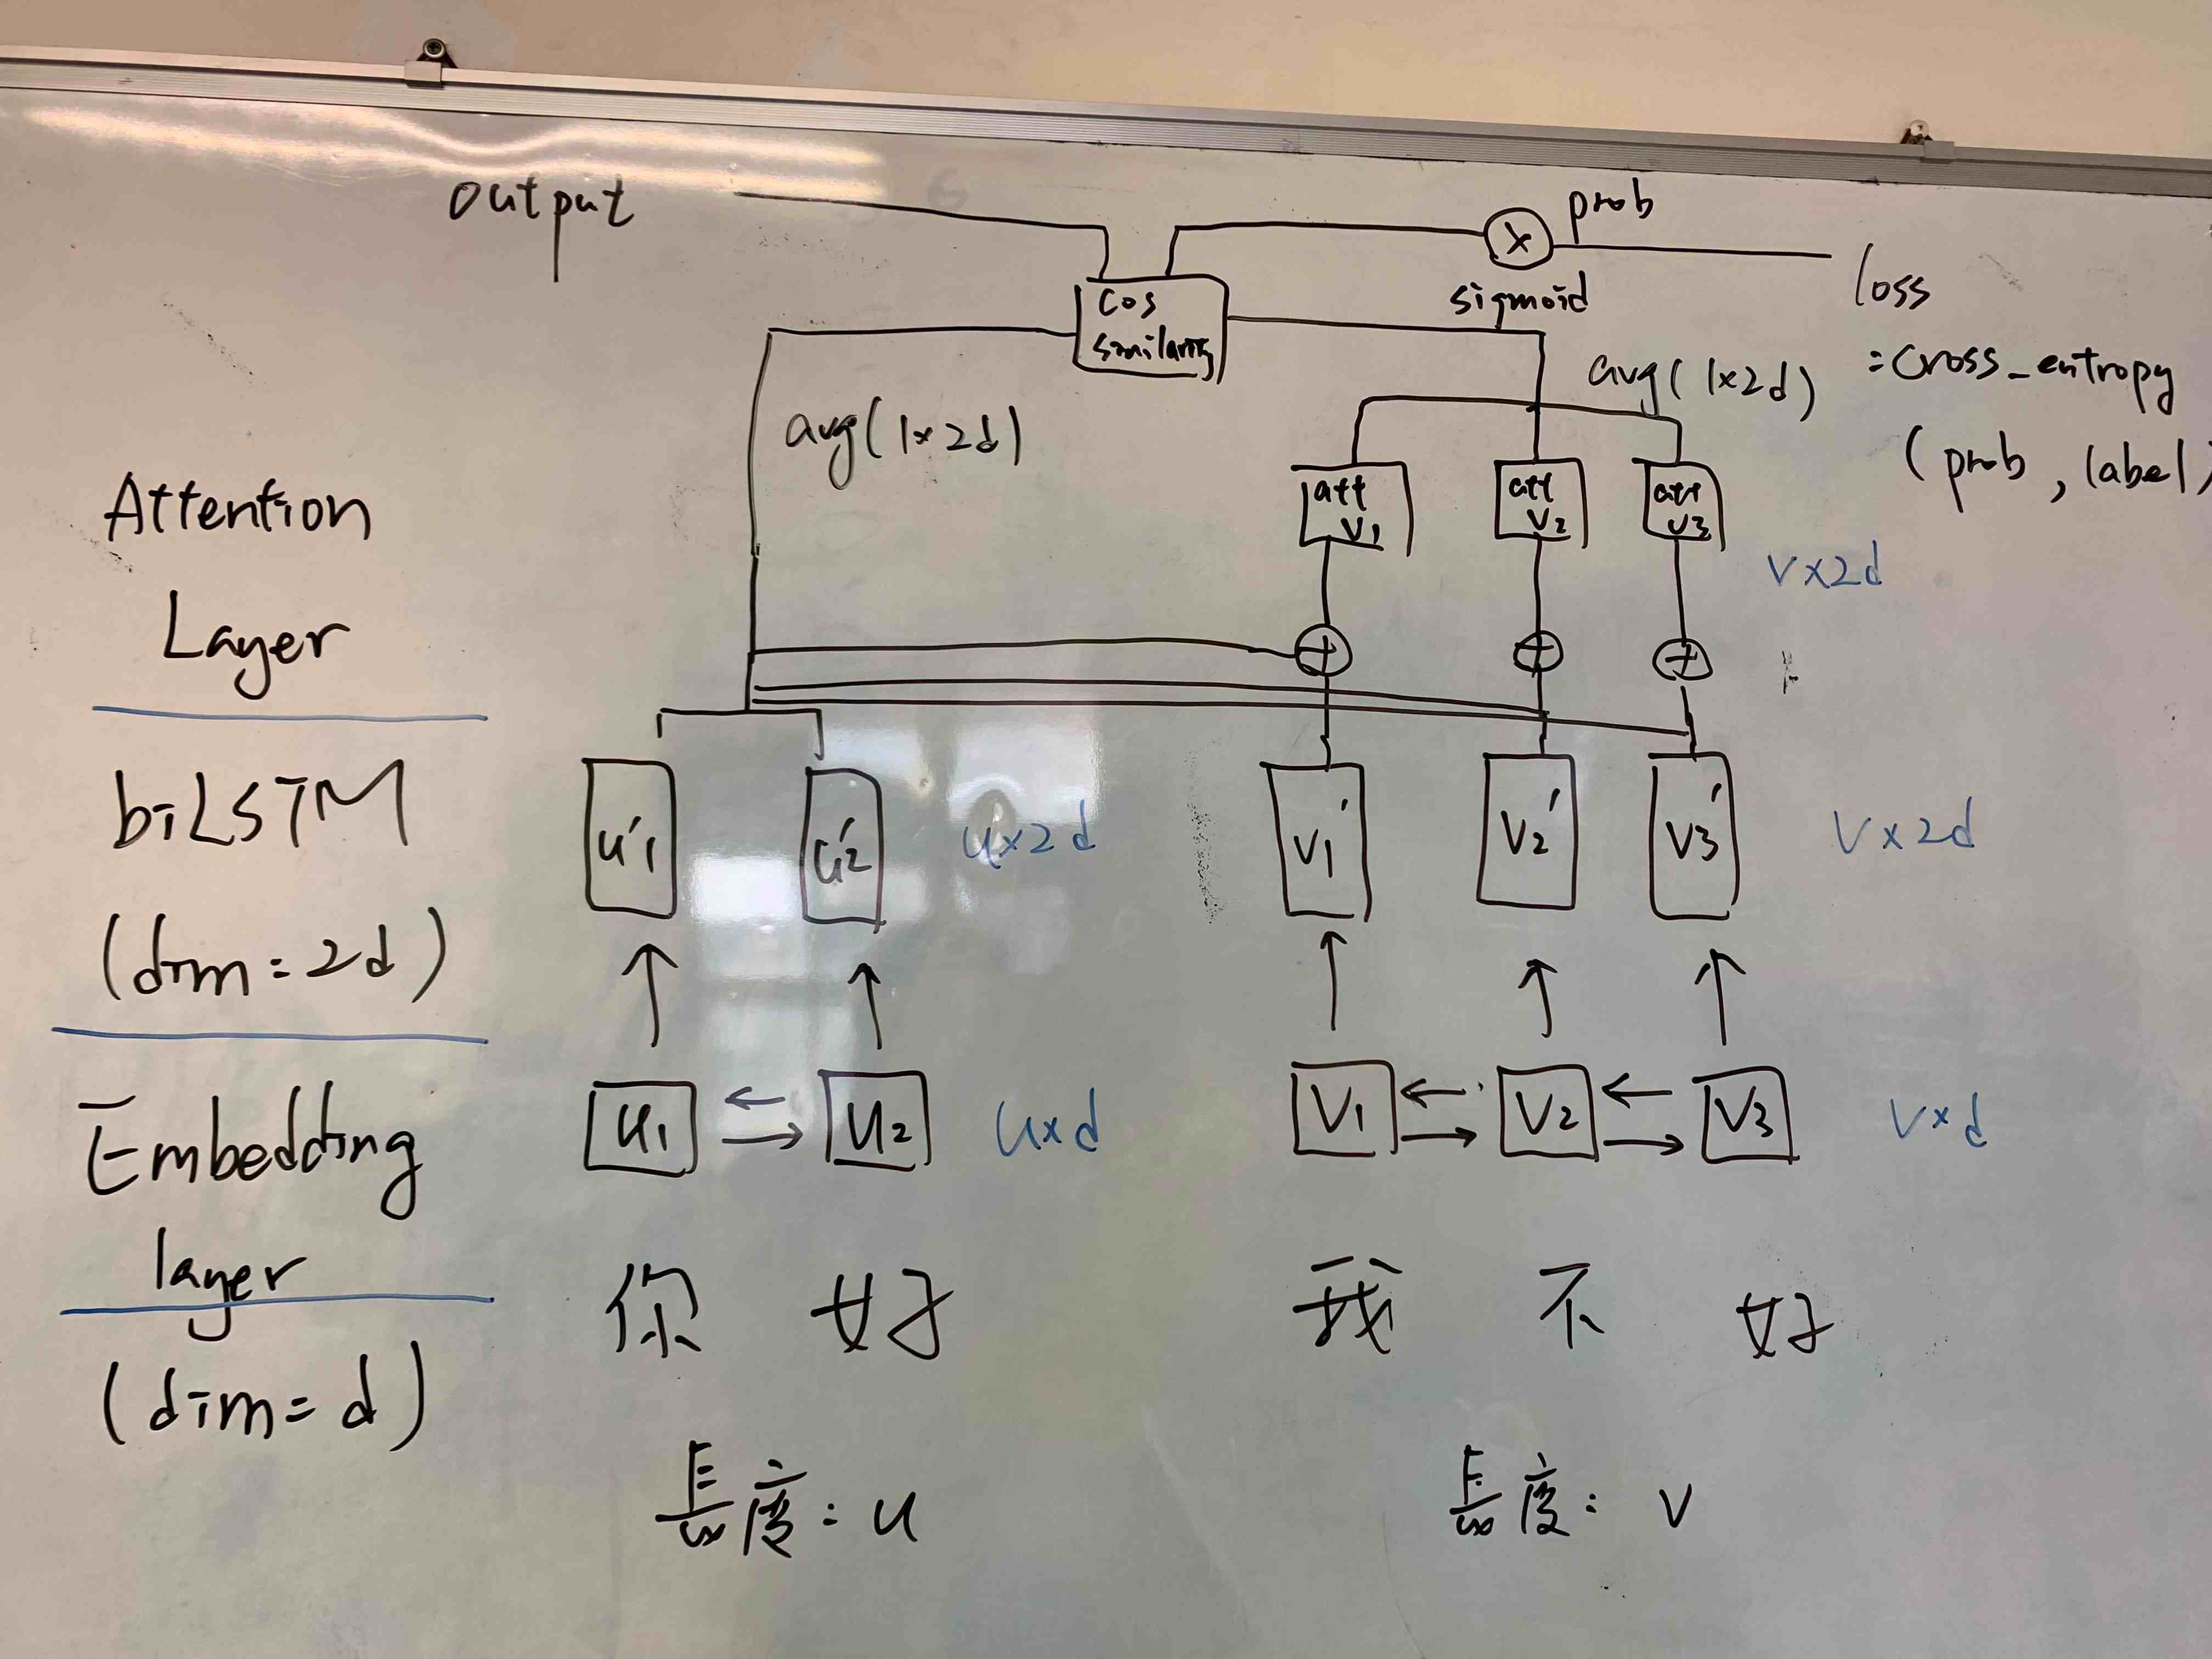

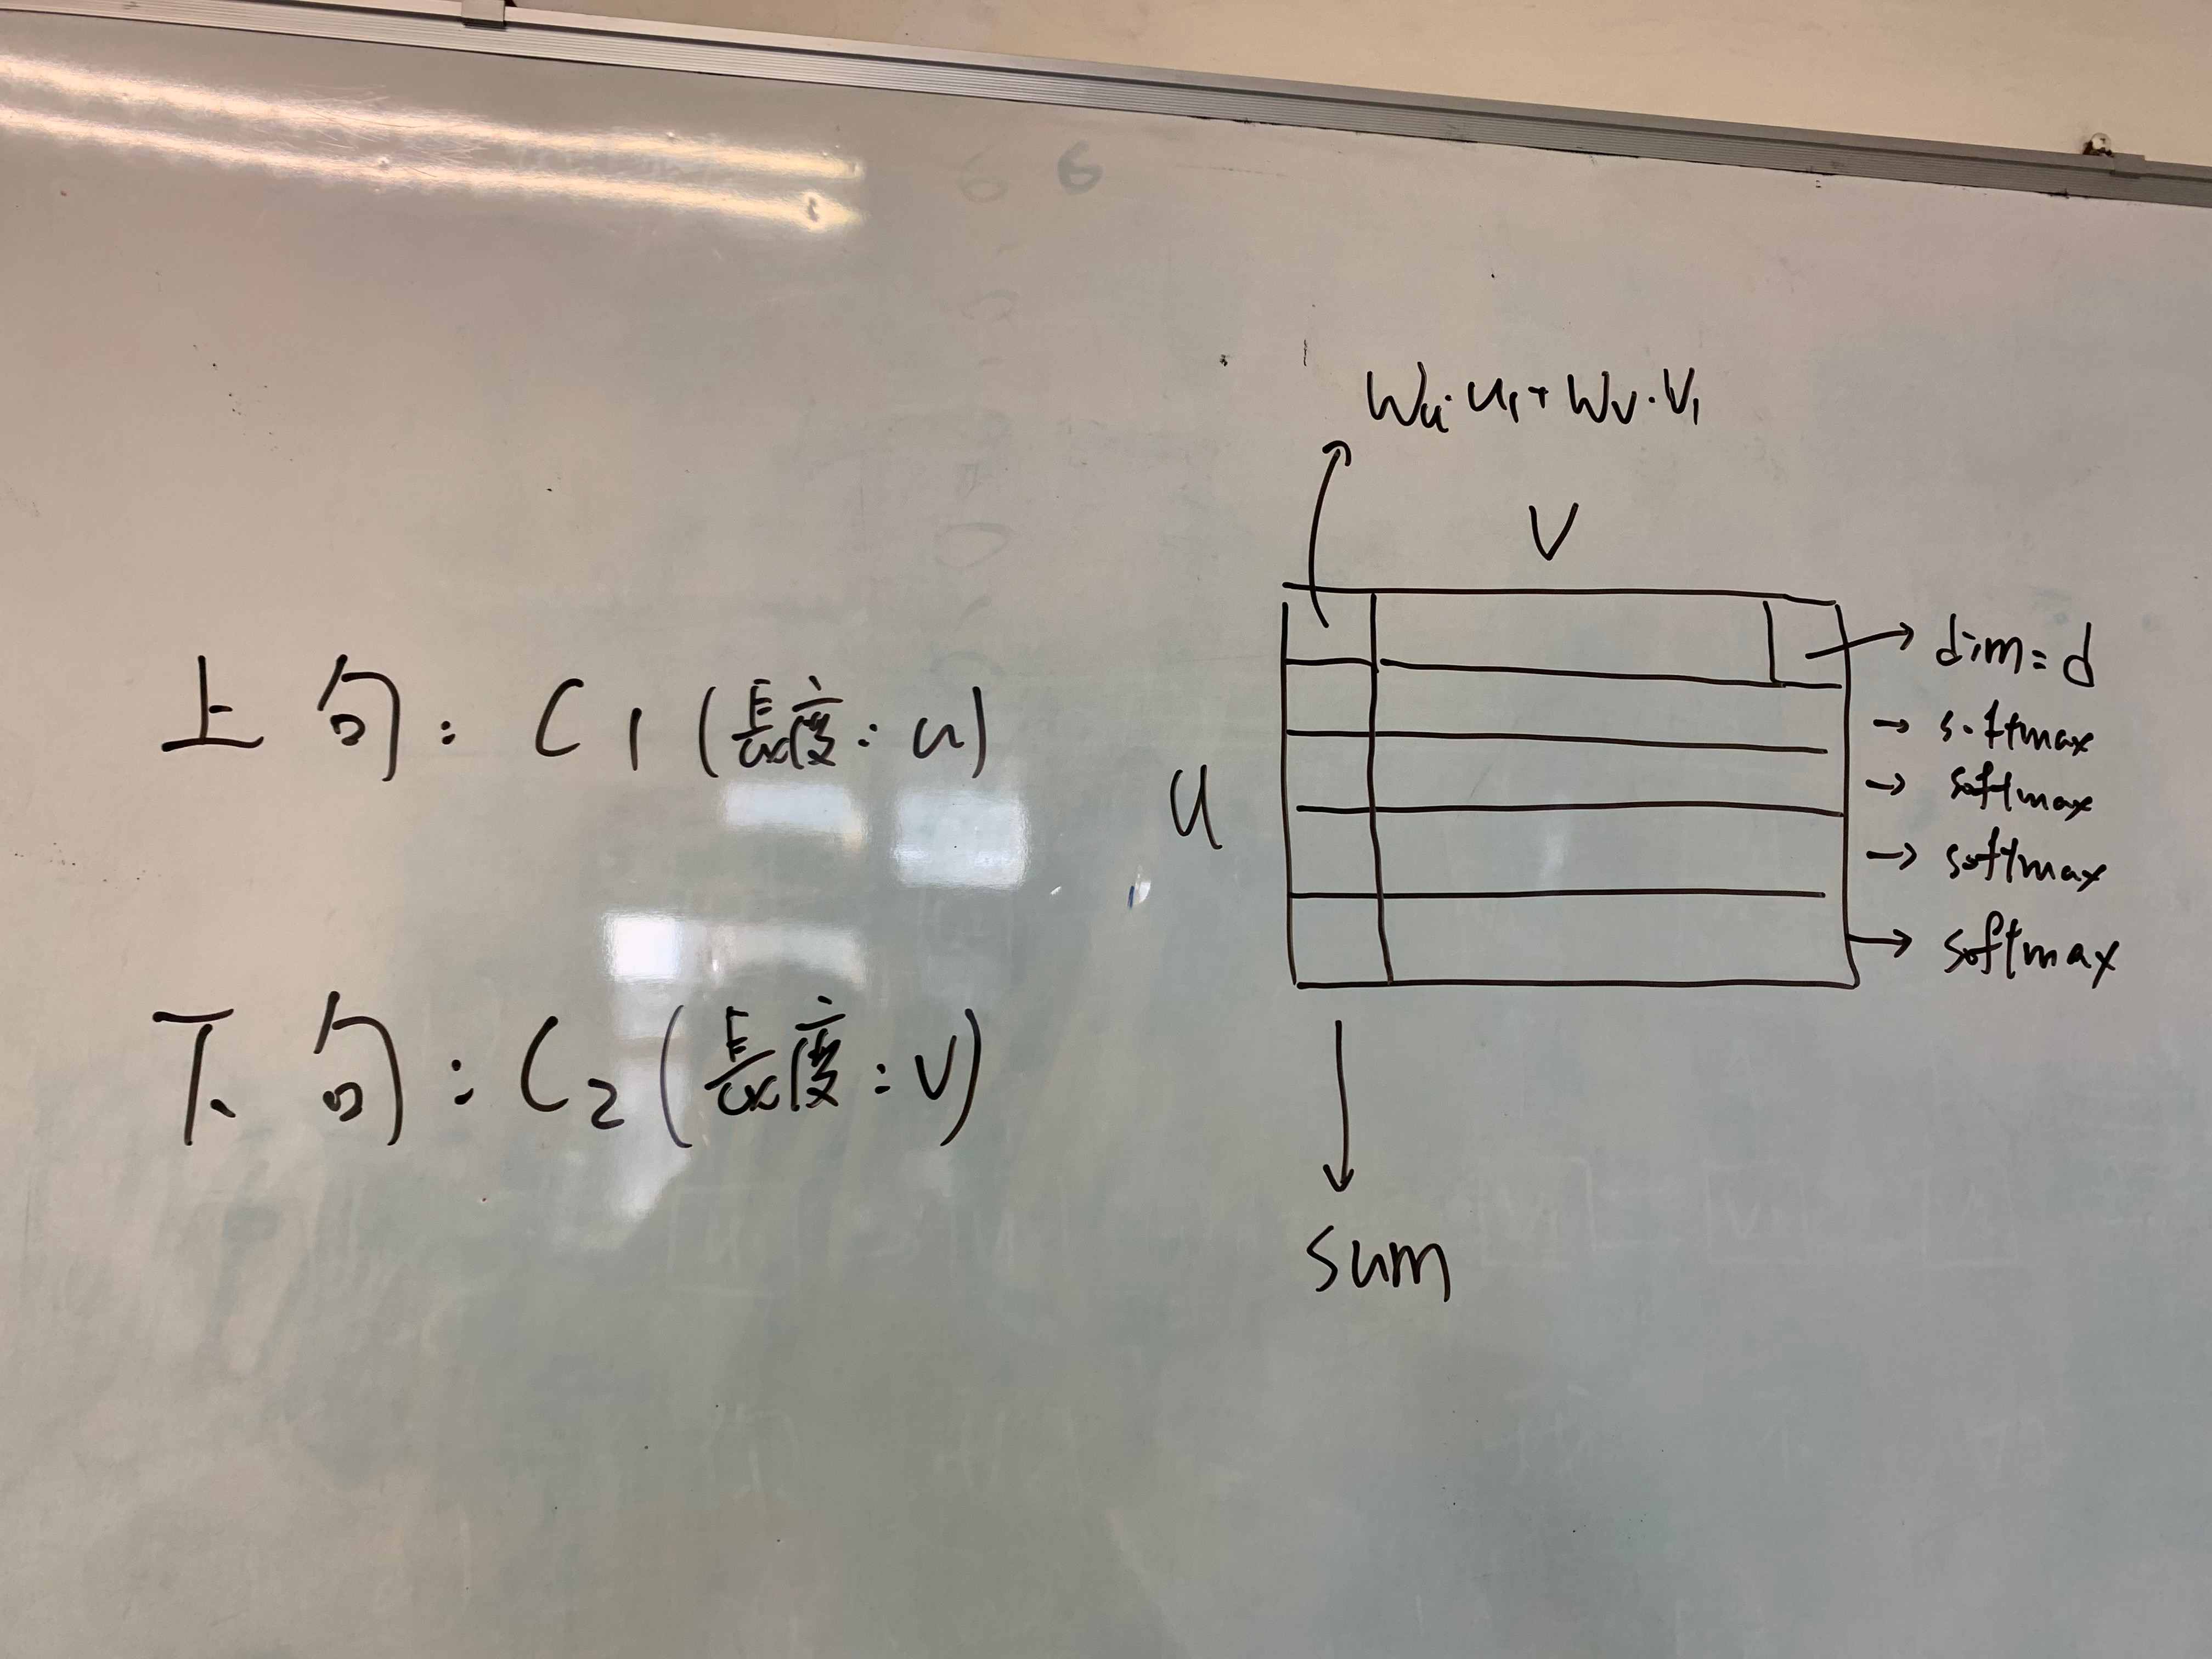

In [25]:
class Model:
    """
    Init necessarary parameter
    """
    def __init__(self):
        self.embedding_path = embedding_path
        self.fmodel = FastText.load(self.embedding_path)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.word_dim = len(self.fmodel.wv.vocab) + 1
        self.vocab = defaultdict(int)
        self.dropout = dropout
        self.use_cudnn = True

        index = 1
        for vocab in self.fmodel.wv.vocab:
            self.vocab[vocab] = index
            index += 1

    """
    Use a N x d matrix for word embedding, N is the number of words, d is embedding dimension
    """
    def embed(self):
        vec = np.zeros((self.word_dim, self.embedding_dim), dtype=np.float32)

        for vocab in self.fmodel.wv.vocab:
            vec[self.vocab[vocab]] = self.fmodel.wv[vocab]

        embedding = C.parameter(shape=vec.shape, init=vec)

        def func(context):
            return C.times(context, embedding)

        return func

    """
    A single shared weights bidirectional RNN for encoding
    """
    def input_layer(self, c1w, c2w):
        c1w_ph = C.placeholder()
        c2w_ph = C.placeholder()

        input_words = C.placeholder(shape=(self.word_dim))

        embedded = self.embed()(input_words)
        processed = OptimizedRnnStack(self.hidden_dim,
                       num_layers=1, bidirectional=True, use_cudnn=True, name='input_rnn')(embedded)

        c1_processed = processed.clone(C.CloneMethod.share, {input_words: c1w_ph})
        c2_processed = processed.clone(C.CloneMethod.share, {input_words: c2w_ph})

        return C.as_block(
            C.combine([c1_processed, c2_processed]),
            [(c1w_ph, c1w), (c2w_ph, c2w)],
            'input_layer',
            'input_layer'
        )
    
    """
    A very important layer that weight the important word, which can accelerate the accuracy
    """
    def attention_layer(self, c1, c2, layer):
        q_processed = C.placeholder(shape=(2*self.hidden_dim,))
        p_processed = C.placeholder(shape=(2*self.hidden_dim,))

        qvw, qvw_mask = C.sequence.unpack(q_processed, padding_value=0).outputs

        wq = C.parameter(shape=(2*self.hidden_dim, 2*self.hidden_dim), init=C.glorot_uniform())
        wp = C.parameter(shape=(2*self.hidden_dim, 2*self.hidden_dim), init=C.glorot_uniform())
        wg = C.parameter(shape=(8*self.hidden_dim, 8*self.hidden_dim), init=C.glorot_uniform())
        v = C.parameter(shape=(2*self.hidden_dim, 1), init=C.glorot_uniform())

        # seq[tensor[2d]] p_len x 2d
        wpt = C.reshape(C.times(p_processed, wp), (-1, 2*self.hidden_dim))

        # q_len x 2d
        wqt = C.reshape(C.times(qvw, wq), (-1, 2*self.hidden_dim))

        # seq[tensor[q_len]]
        S = C.reshape(C.times(C.tanh(C.sequence.broadcast_as(wqt, p_processed) + wpt), v), (-1))

        qvw_mask_expanded = C.sequence.broadcast_as(qvw_mask, p_processed)

        # seq[tensor[q_len]]
        S = C.element_select(qvw_mask_expanded, S, C.constant(-1e+30))

        # seq[tensor[q_len]]
        A = C.softmax(S, axis=0)

        # seq[tensor[2d]]
        swap_qvw = C.swapaxes(qvw)
        cq = C.reshape(C.reduce_sum(A * C.sequence.broadcast_as(swap_qvw, A), axis=1), (-1))

        # seq[tensor[4d]]
        uc_concat = C.splice(p_processed, cq, p_processed * cq, cq * cq)

        # seq[tensor[4d]]
        gt = C.tanh(C.times(uc_concat, wg))

        # seq[tensor[4d]]
        uc_concat_star = gt * uc_concat

        # seq[tensor[4d]]
        vp = C.layers.Sequential([
            C.layers.Dropout(self.dropout),
            OptimizedRnnStack(self.hidden_dim, bidirectional=True,
                use_cudnn=self.use_cudnn, name=layer+'_attention_rnn')])(uc_concat_star)

        return C.as_block(
            vp,
            [(p_processed, c1), (q_processed, c2)],
            'attention_layer_' + layer,
            'attention_layer_' + layer)
    
    """
    Build the model
    """
    def model(self):
        c1_axis = C.Axis.new_unique_dynamic_axis('c1_axis')
        c2_axis = C.Axis.new_unique_dynamic_axis('c2_axis')
        b = C.Axis.default_batch_axis()

        c1 = C.input_variable(self.word_dim, dynamic_axes=[b, c1_axis], name='c1')
        c2 = C.input_variable(self.word_dim, dynamic_axes=[b, c2_axis], name='c2')

        y = C.input_variable(1, dynamic_axes=[b], name='y')

        c1_processed, c2_processed = self.input_layer(c1, c2).outputs
        att_context = self.attention_layer(c2_processed, c1_processed, 'attention')

        c2_len = C.layers.Fold(plus1)(c2_processed)
        att_len = C.layers.Fold(plus1)(att_context)

        cos = C.cosine_distance(C.sequence.reduce_sum(c2_processed)/c2_len,
                                C.sequence.reduce_sum(att_context)/att_len)

        prob = C.sigmoid(cos)
        is_context = C.greater(prob, 0.5)

        loss = C.losses.binary_cross_entropy(prob, y)
        acc = C.equal(is_context, y)

        return cos, loss, acc

In [26]:
"""
Train from a new model or the checkpoint
"""

def train(ckpt, logdir):
    model = Model()
    z, loss, acc = model.model()

    progress_writers = [C.logging.ProgressPrinter(
                            num_epochs = max_epochs,
                            freq = log_freq,
                            tag = 'Training',
                            log_to_file = logdir + '/' + version + '.log')]

    lr = C.learning_parameter_schedule(learning_rate, minibatch_size=None, epoch_size=None)
    learner = C.adadelta(z.parameters, lr)
    trainer = C.Trainer(z, (loss, acc), learner, progress_writers)

    mb_source, input_map = deserialize(loss, train_data, model)
    mb_valid, valid_map = deserialize(loss, valid_data, model)

    try:
        trainer.restore_from_checkpoint(ckpt)
    except Exception:
        print('No checkpoint founded.')
        
    for epoch in range(max_epochs):
        num_seq = 0
        # train
        with tqdm(total=epoch_size, desc='Epoch {} train'.format(epoch)) as progress_bar:
            while True:
                data = mb_source.next_minibatch(minibatch_size, input_map=input_map)
                trainer.train_minibatch(data)
                num_seq += trainer.previous_minibatch_sample_count
                progress_bar.update(trainer.previous_minibatch_sample_count)
                if num_seq >= epoch_size:
                    break
            trainer.summarize_training_progress()
            trainer.save_checkpoint('../model/' + version + '/' + str(epoch))
        num_seq = 0
        # validation
        with tqdm(total=num_validation, desc='Epoch {} validate'.format(epoch)) as valid_progress_bar:
            while True:
                data = mb_valid.next_minibatch(minibatch_size, input_map=valid_map)
                if not data:
                    break
                trainer.test_minibatch(data)
                num_seq += len(data)
                valid_progress_bar.update(len(data))
                if num_seq >= num_validation:
                    break
            trainer.summarize_test_progress()

In [27]:
"""
Inference each context relationship
"""

def inference(model, test):
    p = Model()
    model = C.load_model(model)

    cos = model.outputs[0]
    loss = C.as_composite(model.outputs[1].owner)

    mb_test, map_test = deserialize(loss, test, p,
                                    randomize=False, repeat=False, is_test=True)
    c1 = argument_by_name(loss, 'c1')
    c2 = argument_by_name(loss, 'c2')

    results = []
    if 'test' in test:
        total_samples = 3000
    else:
        total_samples = num_validation

    with tqdm(total=total_samples) as progress_bar:
        while True:
            data = mb_test.next_minibatch(minibatch_size, input_map=map_test)
            progress_bar.update(len(data))
            if not data:
                break
            out = model.eval(data, outputs=[cos])
            results.extend(out)
    assert(len(results) == total_samples)
    return results

In [28]:
"""
Write the prediction with maximum relationship
"""

def write_prediction(results, datadir, output):
    questions = np.load(datadir + '/tokenized_questions.npy')
    predict = list()
    for index in range(0, len(results), 6):
        sample = results[index:index + 6]
        predict.append(np.argmax(sample))

    with open(output, 'w', encoding='utf-8') as out:
        out.write('Id,Answer\n')
        for idx, p in enumerate(predict):
            out.write(str(idx) + ',' + str(p) + '\n')

# Experiments

In [29]:
import pygal

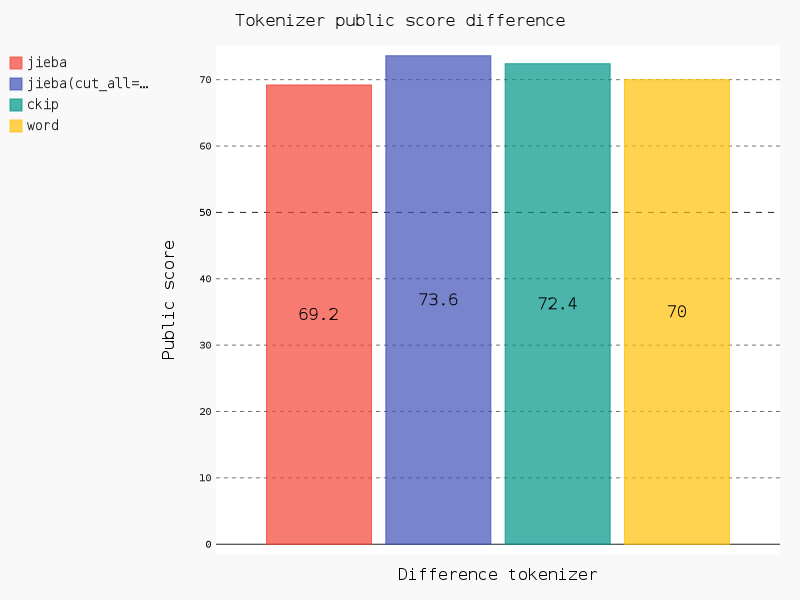

In [30]:
"""
Here we show the difference of tokenizers
"""

line_chart = pygal.Bar(print_values=True)
line_chart.title = 'Tokenizer public score difference'
line_chart.x_title = 'Difference tokenizer'
line_chart.y_title = 'Public score'
line_chart.add('jieba',  [69.2])
line_chart.add('jieba(cut_all=True)',  [73.6])
line_chart.add('ckip',  [72.4])
line_chart.add('word',  [70])
line_chart

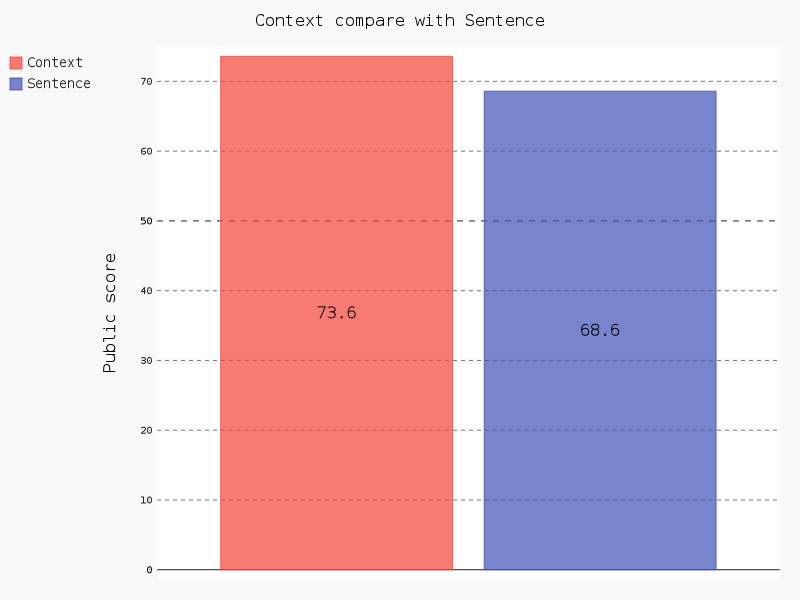

In [31]:
"""
Here we show the performance difference trained with context level and sentence level
"""

line_chart = pygal.Bar(print_values=True)
line_chart.title = 'Context compare with Sentence'
line_chart.y_title = 'Public score'
line_chart.add('Context',  [73.6])
line_chart.add('Sentence',  [68.6])
line_chart

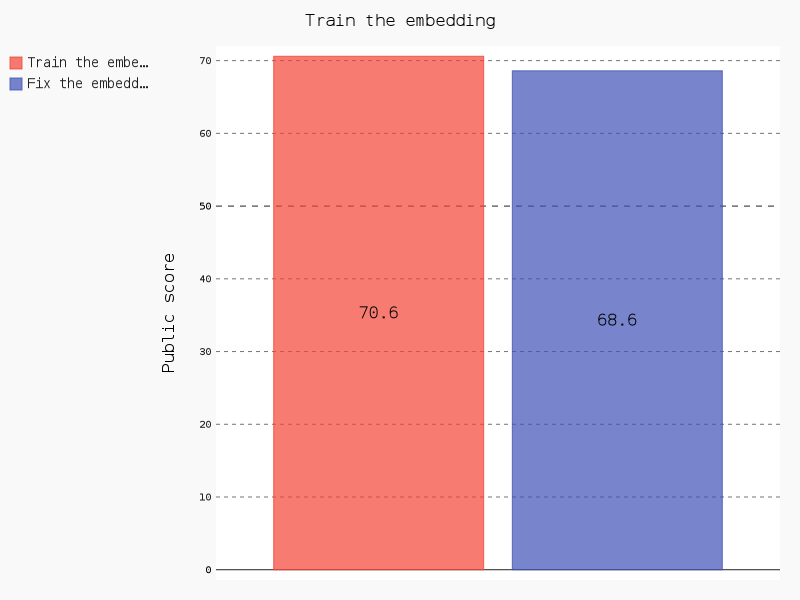

In [32]:
"""
Here we show the performance of fixed and not fixed embedding
"""

line_chart = pygal.Bar(print_values=True)
line_chart.title = 'Train the embedding'
line_chart.y_title = 'Public score'
line_chart.add('Train the embedding',  [70.6])
line_chart.add('Fix the embedding',  [68.6])
line_chart

### Next cell we will show the accuracy of different network size, and here is the configurations


<table>
<thead>
<tr>
<th></th>
<th>Embedding dimension</th>
<th>LSTM hidden dimension</th>
</tr>
</thead>
<tbody>
<tr>
<td>Small configuration</td>
<td>300</td>
<td>256</td>
</tr>
<tr>
<td>Medium configuration</td>
<td>384</td>
<td>256</td>
</tr>
<tr>
<td>Large configuration</td>
<td>600</td>
<td>300</td>
</tr>
<tr>
<td>Ultra large configuration</td>
<td>1200</td>
<td>300</td>
</tr>
<tr>
<td>Super ultra large configuration</td>
<td>2048</td>
<td>300</td>
</tr>
</tbody>
</table>

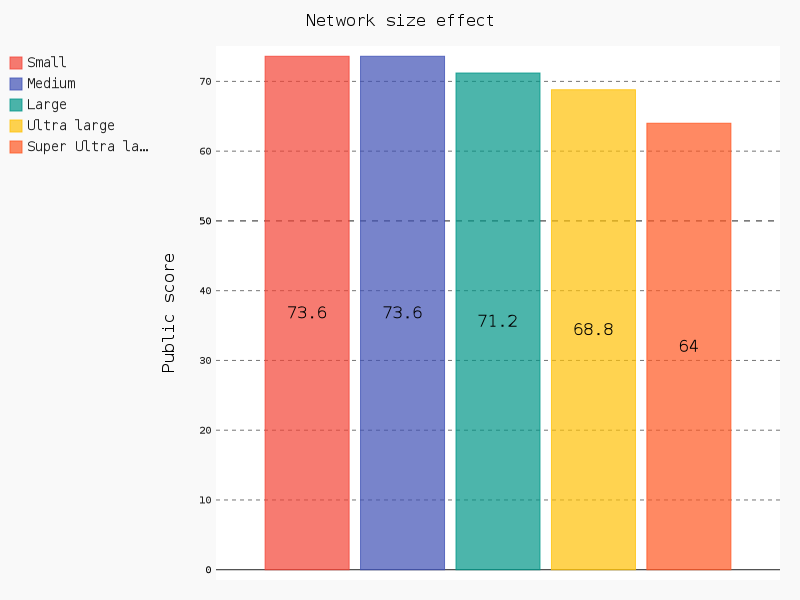

In [33]:
"""
Here we show the performance of different network size
"""

line_chart = pygal.Bar(print_values=True)
line_chart.title = 'Network size effect'
line_chart.y_title = 'Public score'
line_chart.add('Small',  [73.6])
line_chart.add('Medium',  [73.6])
line_chart.add('Large',  [71.2])
line_chart.add('Ultra large',  [68.8])
line_chart.add('Super Ultra large',  [64])
line_chart

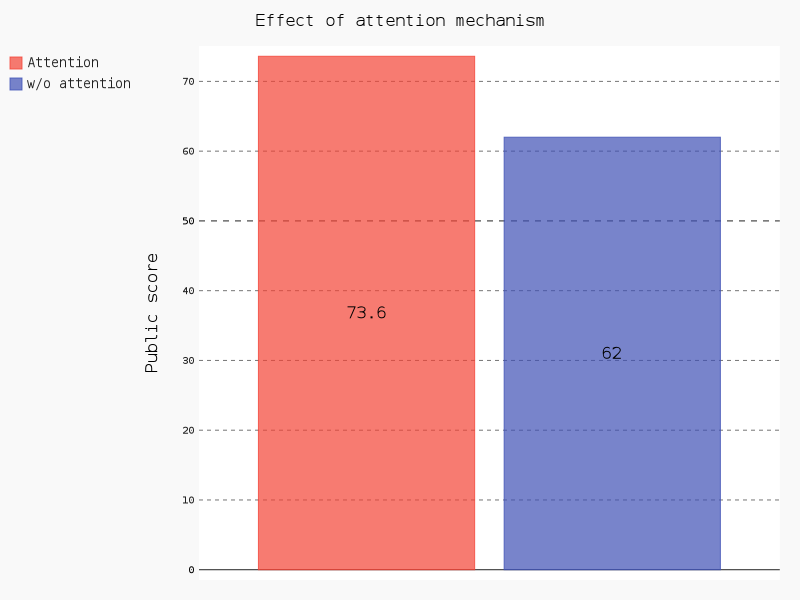

In [34]:
"""
Here we show the effect of attention mechanism
"""

line_chart = pygal.Bar(print_values=True)
line_chart.title = 'Effect of attention mechanism'
line_chart.y_title = 'Public score'
line_chart.add('Attention',  [73.6])
line_chart.add('w/o attention',  [62])
line_chart

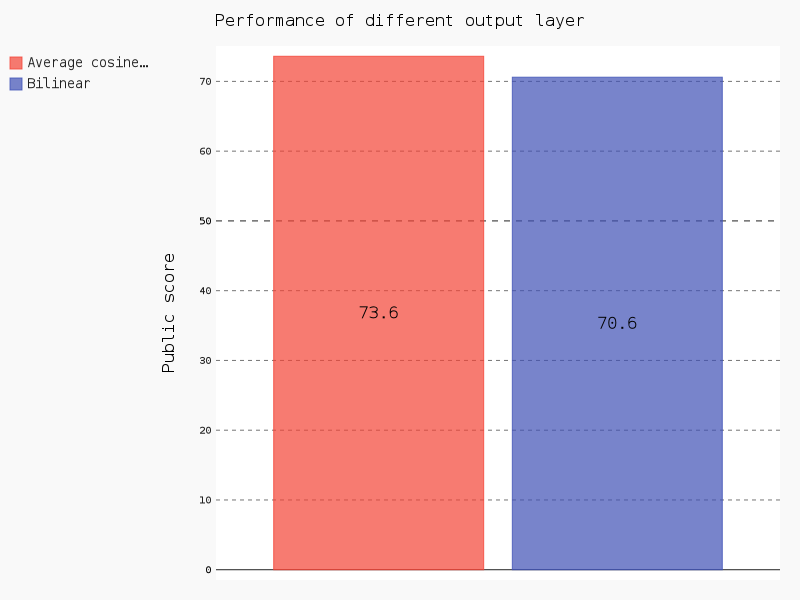

In [35]:
"""
Here we show the performance of differnt output layer
"""

line_chart = pygal.Bar(print_values=True)
line_chart.title = 'Performance of different output layer'
line_chart.y_title = 'Public score'
line_chart.add('Average cosine similarity',  [73.6])
line_chart.add('Bilinear',  [70.6])
line_chart

# Conclusion

In this competition, we designed our own Chinese Appropriate Answer Prediction model, and get the second prize in the competition. In this competition, we learned a lot of things, include how to process data, mine the features from text, learn a efficient framework and several days team work. It's a interesting and cool competition for us for the first deep learning project. Thank TA's teach :D